In [1]:
import pandas as pd
df=pd.read_csv("/kaggle/input/final-dataset/zak4_dataset.csv")
# df.head()
df.columns = ['Text', 'Label']
df.head()


,Text,Label
0,مستعد تبرع بئء الف إنشاء مركز ملك إنسانيه إيوا...,normal
1,مبروك حريه بطل طفل أصغر أسير سجن احتلال عشتي ح...,normal
2,تويت ماضي,normal
3,بحس عمل رتويت سلخ وبرت هاي سالف صغير فضل سلخ إ...,normal
4,هذيك بنت تطلع جوز حبك طبع بنت سرحان جاي عبال ن...,normal


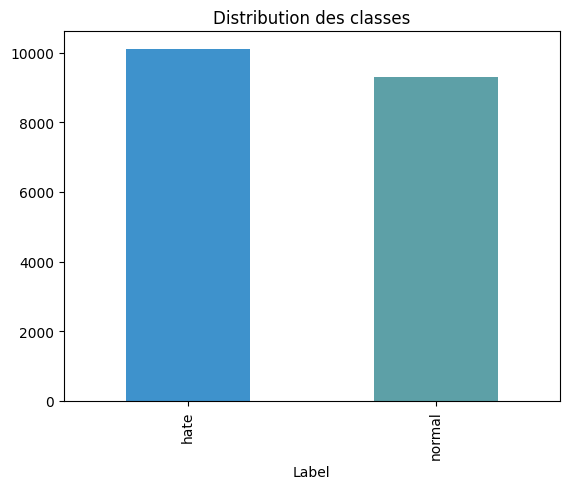

In [4]:
import matplotlib.pyplot as plt
df["Label"].value_counts().plot(kind="bar", color=["#3E92CC", "#5DA0A7"])
plt.title("Distribution des classes")
plt.show()

In [4]:
print(df['Label'].value_counts())

Label
hate      10104
normal     9308
Name: count, dtype: int64


In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

label_mapping = {"hate": 1, "normal": 0}
df["Label"] = df["Label"].map(label_mapping)
df_clean = df[["Text", "Label"]].dropna()

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_clean["Text"],
    df_clean["Label"],
    test_size=0.2,
    random_state=42
)

# Charger le tokenizer AraBERT
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv02")

def tokenize_data(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=512)

train_encodings = tokenize_data(train_texts)
test_encodings = tokenize_data(test_texts)

class HateSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Convertir en dataset PyTorch
train_dataset = HateSpeechDataset(train_encodings, train_labels.tolist())
test_dataset = HateSpeechDataset(test_encodings, test_labels.tolist())

model = AutoModelForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabertv02", num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,  
    num_train_epochs=5,
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none",
    warmup_steps=500,
    learning_rate=2e-5,
    weight_decay=0.01,
    lr_scheduler_type="linear",
   
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]  
)

trainer.train()


2025-04-26 23:48:37.963478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745711318.149953      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745711318.206047      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.221059,0.909583
2,0.378300,0.214627,0.914219
3,0.191100,0.225622,0.921432
4,0.119900,0.282795,0.926069


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1944, training_loss=0.19503869931884263, metrics={'train_runtime': 795.235, 'train_samples_per_second': 97.632, 'train_steps_per_second': 3.056, 'total_flos': 2681167431882240.0, 'train_loss': 0.19503869931884263, 'epoch': 4.0})

In [8]:
results = trainer.evaluate()
print("✅ Résultats de l'évaluation :", results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Résultats de l'évaluation : {'eval_loss': 0.21462726593017578, 'eval_accuracy': 0.9142194744976816, 'eval_runtime': 17.3254, 'eval_samples_per_second': 224.064, 'eval_steps_per_second': 7.042, 'epoch': 4.0}


In [9]:
from sklearn.metrics import classification_report
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)
                                                            
print(classification_report(y_true, y_pred))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      0.88      0.90      1789
           1       0.90      0.94      0.92      2093

    accuracy                           0.91      3882
   macro avg       0.92      0.91      0.91      3882
weighted avg       0.91      0.91      0.91      3882



In [11]:
model.save_pretrained("./zak_model")

In [10]:
torch.save(model.state_dict(), 'model.pth')